# Описание проекта

**КОНТЕКСТ**

*Аналитиком крупного интернет-магазина совместно с отделом маркетинга был подготовлен список из 9 гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.*

**ОПИСАНИЕ ДАННЫХ**

***ЧАСТЬ 1***

Файл  со списком гипотез для увеличения выручки`/datasets/hypothesis.csv.` 

`Hypothesis` — краткое описание гипотезы;

`Reach` — охват пользователей по 10-балльной шкале;

`Impact` — влияние на пользователей по 10-балльной шкале;

`Confidence` — уверенность в гипотезе по 10-балльной шкале;

`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

***ЧАСТЬ 2***

Файл с данными анализа A/B-теста о заказах `/datasets/orders.csv.`

`transactionId` — идентификатор заказа;

`visitorId` — идентификатор пользователя, совершившего заказ;

`date` — дата, когда был совершён заказ;

`revenue` — выручка заказа;

`group` — группа A/B-теста, в которую попал заказ.

Файл с данными анализа A/B-теста о пользователях `/datasets/visitors.csv.`

`date` — дата;

`group` — группа A/B-теста;

`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

Загрузим необходимые для работы над проектом библиотеки и три датасета для исследования, рассмотрим общую информацию о данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
hypothesis, orders, visitors  = (
    pd.read_csv('/datasets/hypothesis.csv'), # гипотезы
    pd.read_csv('/datasets/orders.csv'), # заказы
    pd.read_csv('/datasets/visitors.csv'), # пользователи
)

In [3]:
for data in [hypothesis, orders, visitors]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 col

In [4]:
for data in [hypothesis, orders, visitors]: 
    display(data.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Уберем из названий столбцов в таблице `hypothesis` заглавные буквы, типы столбцов с датами в `orders`, `visitors` приведем  к datetime

Пропущенных значений в датасетах нет, в целом данные "ровные"

In [5]:
hypothesis.columns = [x.lower().replace(' ', '_') for x in hypothesis.columns.values]

In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
for data in [hypothesis, orders, visitors]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None

<class 'pandas.core.

In [8]:
for data in [orders['revenue'], visitors['visitors']]: 
    print(data.describe(), end='\n\n')

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64



Проверим на дубликаты

In [9]:
for data in [hypothesis, orders, visitors]: 
    print('Кол-во дубликатов =',data.duplicated().sum(), end='\n\n')

Кол-во дубликатов = 0

Кол-во дубликатов = 0

Кол-во дубликатов = 0




<b>ВЫВОД 1 </b>
    
Датасет `hypothesis` состоит из 5 столбцов, 9 строк. Данные в таблице полные, корректные, дубликатов нет. Изменены названия столбцов

Датасет `orders` состоит из 5 столбцов, 1197 строк. Данные в таблице полные, распределены неравномерно, корректные, дубликатов нет. Изменен лишь тип столбцов с датами на "datetime" в одном столбце
    
Датасет `visitors` состоит из 3 столбцов, 62 строк. Данные в таблице полные, корректные, распределены равномерно, дубликатов нет. Изменен лишь тип столбцов с датами на "datetime" в одном столбце

## Приоритизация гипотез

In [10]:
pd.set_option('display.max_colwidth', 500)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### ICE
Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [11]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
hypothesis[['ICE', 'hypothesis']].sort_values(by='ICE', ascending=False)

,ICE,hypothesis
8,16.20,"Запустить акцию, дающую скидку на товар в день рождения"
0,13.33,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
7,11.20,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
6,8.00,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
2,7.00,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
1,2.00,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,1.33,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
3,1.12,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
4,1.00,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


### RICE


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [12]:
hypothesis['RICE'] = (hypothesis['reach']  * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['RICE', 'hypothesis', 'reach']].sort_values(by='RICE', ascending=False)

,RICE,hypothesis,reach
7,112.0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10
2,56.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8
0,40.0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3
6,40.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5
8,16.2,"Запустить акцию, дающую скидку на товар в день рождения",1
3,9.0,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8
1,4.0,"Запустить собственную службу доставки, что сократит срок доставки заказов",2
5,4.0,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3
4,3.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3



<b>ВЫВОД 2 </b>
    
Тройка лидеров `ICE`:
    
1. Гипотеза №9 (16.2)
    
2. Гипотеза №1 (13.33)
    
3. Гипотеза №8 (11.2)
    
Тройка лидеров `RICE`:
    
1. Гипотеза №8 (112)
    
2. Гипотеза №3 (56)
    
3. Гипотеза №1 и гипотеза №7 (40)
    
Различие в приоритизации гипотез по фреймворкам очевидно. Лидер тройки `ICE	` спустился аж на 5ю позицию в `RICE`, второе место спустилось на третье, а третье стало первым. И противоположно - гипотеза №3, занимающая в `ICE	` пятое место, в `RICE` занялауверенное второе. 
    
Такое **отличие**, вероятно, **обусловлено учетом** во фреймворке `RICE`  **параметра `reach`** (количество пользователей, которых затронет вносимое нами изменение), и в гипотезах №8 и №2 его значения высоки:
    
1. Гипотеза №8 (7): `reach` = 10 (макимум)
    
2. Гипотеза №3 (2): `reach` = 8 (высокий)
    
Тогда как у лидера `ICE` *Гипотеза №9 (8): `reach` = 1 (минимум)* 
    
**Рекомендую для** проведения **тестирования** следующие **гипотезы**:
    
а). Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок ***(точно)***
    
б). Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа ***(возможно)***	

## Анализ A/B-теста

### График кумулятивной выручки по группам

 Данные для расчетов по выручке хранятся в датасете с результатами проведения А/В-теста `orders`:

In [13]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Как мы заметили в ходе предобработки, данные по выручке распределены неравномерно. Поэтому в качестве усредненного значения посчитаем *медианное значение выручки по каждой группе*

In [14]:
orders.groupby(['date','group'])['revenue'].sum().groupby('group').median()

group
A    112473
B    147274
Name: revenue, dtype: int64

Видим различие по группам

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates().  

In [15]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах.

In [16]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transactionId' : pd.Series.nunique, 
                                          'visitorId' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [17]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

In [18]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

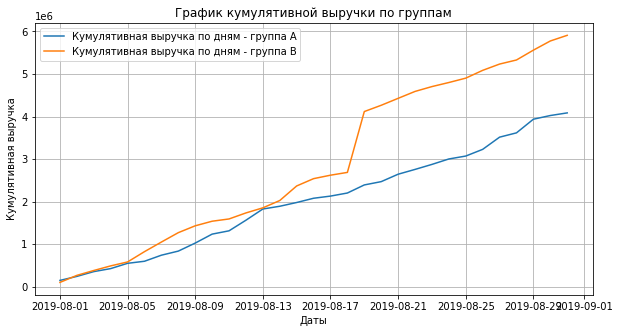

In [19]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кумулятивная выручка по дням - группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кумулятивная выручка по дням - группа B')
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.legend() 
plt.xlabel('Даты')
plt.ylabel('Кумулятивная выручка')
plt.show()


18-19 августа наблюддается резкий скачок выручки группы `B`. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Без этого скачка данные распределились бы практически равномерно. Изучим поподробнее сегмент между 17 и 21 августа

In [20]:
cumulativeRevenueB.query('"2019-08-17" <= date <= "2019-08-21"')

,date,revenue,orders
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423
41,2019-08-21,4426892,437


Посчитаем медиану одного заказа 19 августа

In [21]:
orders.query(' date == "2019-08-19" ')['revenue'].median()

2630.0

In [22]:
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B
525,3031564664,393266494,2019-08-19,21550,A
368,3268879337,2536252163,2019-08-19,20026,B
366,2037051350,1957949546,2019-08-19,16770,A
463,4170537404,290022471,2019-08-19,16480,B
531,4016435970,4017075195,2019-08-19,13390,A



<b>ВЫВОД 3.1 </b>
    
В первой половине августа выручка в группе `B` растёт немного быстрее, чем в группе `A`. 

13 августа выручки обеих групп практически равны. 

Во второй половине месяца все становится более показательно, выручка группы `B` стабильно выше.

19 августа определен выброс в группе `B` в значении выручки по заказу №425 (порядка 1.3 миллиона, что несопоставимо больше медианного значения в этот день, равного 2630.0 и второго по величине заказа в ~44 тысяч). Учтем этот выброс в дальнейшем исследовании


### График кумулятивного среднего чека

Разделим кумулятивную выручку на кумулятивное число заказов:

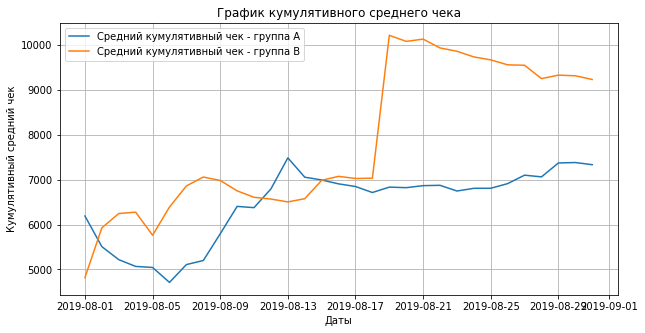

In [23]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Средний кумулятивный чек - группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Средний кумулятивный чек - группа B')
plt.grid()
plt.title('График кумулятивного среднего чека')
plt.legend()
plt.xlabel('Даты')
plt.ylabel('Кумулятивный средний чек')
plt.show()


<b>ВЫВОД 3.2 </b>
    
Прослеживается связь с графиком кумулятивной выручки. 

С первого числа средний чек группы `A` начинает снижение, а группы `B` рост. 
    
В первой половине месяца в группе `B` чек больше, но с 12 по 15 августа - чек выше в группе `A`.

И далее чек группы `B` стабильно выше. 
    
Видим сильное влияние на средний чек, которое оказывает заказ под номером 425 (помним о нем). После 19 августа средний чек в `B` пошел на снижение.

В группе `A`после 18 августа наблюдается тенденция к плавному росту среднего чека


### График относительного изменения кумулятивного среднего чека

Соберем данные в одном датафрейме, поcтроим отношение средних чеков, добавим горизонтальную ось методом axhline() 

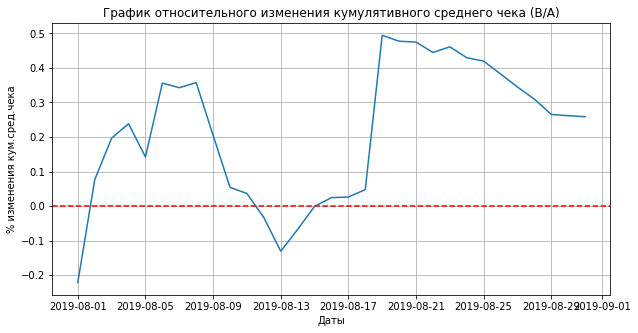

In [24]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека (В/А)')
plt.grid()
plt.axhline(y=0, color='red', linestyle='--') 
plt.xlabel('Даты')
plt.ylabel('% изменения кум.сред.чека')
plt.show()


<b>ВЫВОД 3.3 </b>
    
График частично дублирует выводы кумулятивного среднего чека, т.к. является по сути его производным.

Видим, что средний чек группы `B` пошел в рос с первого дня теста, на сторой день сравнялся со значением в группе `А` и рос до 4 августа. На пятый день немного просел и дальще рос еще три дня. Затем пошел на резкое снижение: с 11-12 по 15 августа был даже ниже показателя группы `А`, достигнув 13-го числа своего "исторического" минимума. Затем видим очень резкий (помним о заказе №425) скачок 19-го августа, после которого пошло плавное снижение к концу месяца.

В нескольких точках график различия между сегментами резко «скачет». Где спрятались крупные заказы и выбросы мы уже частично знаем, остальные найдём их позже.

### График кумулятивной конверсии

Аналогично проанализируем график кумулятивной конверсии. Посчитаем кумулятивную конверсию, отделим данные по группам и построим график

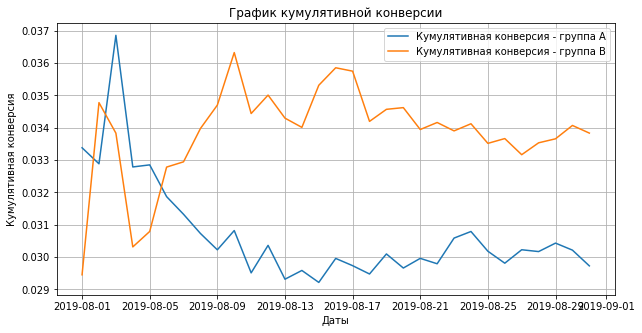

In [25]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Кумулятивная конверсия - группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Кумулятивная конверсия - группа B')
plt.title('График кумулятивной конверсии')
plt.grid()
plt.legend()
plt.xlabel('Даты')
plt.ylabel('Кумулятивная конверсия')
plt.show()


<b>ВЫВОД 3.4 </b>
    
В группе `A` в период 2-5 августа конверсия значительно выше конверсии сравниваемой с ней группы,(3 августа зафиксирован исторический максимум относительно обеих групп), после чего пошло резкое снижение до минимального диапазона значений (0,029-0,031), где конверсия и задержалась на период с 9 августа до конца проведения теста. 
 
Конверсия группы `A` с 4 августа пошла в рост и уже 6 августа превысила конверсию в группе `A`, продолжив расти до 10 августа, затем пошло постепенное снижение, зафиксирован всплеск конверсии в районе 15-17 августа и плавное снижение до конца проведения теста. 
    
В целом, конверсия группы `B` значительно выше группы `A`,начиная с 6 августа. 
    
2 августа конверсии обеих групп подскочили, что может свидетельствовать о реализации какой-то маркетинговой стратегии по предложению скидок или проведению акций в это день.
    
В период с 19 августа графики становятся симметричными, конверсии не зафиксировались.

### График относительного изменения кумулятивной конверсии группы B к группе A

Построим график относительного различия кумулятивных конверсий

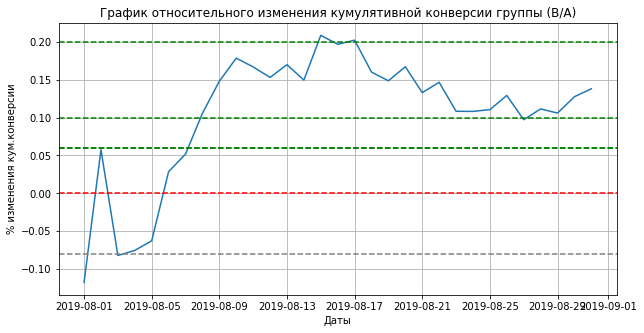

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
                                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивной конверсии группы (B/A)')
plt.grid()
plt.axhline(y=0, color='red', linestyle='--') 
plt.axhline(y=0.1, color='green', linestyle='--')
plt.axhline(y=0.2, color='green', linestyle='--')
plt.axhline(y=0.06, color='green', linestyle='--')
plt.axhline(y=0.06, color='green', linestyle='--')
plt.axhline(y=-0.08, color='grey', linestyle='--')
plt.xlabel('Даты')
plt.ylabel('% изменения кум.конверсии')
plt.show()


<b>ВЫВОД 3.5 </b>
    
Поскольку опять имеем дело с производным графиком от кумулятивной конверсии, то и выводы примерно такие же.
    
1-5 августа  в группе `A` конверсия выше на 5-10% за исключением 2 августа, когда заметен сильный рост конверсии в группе `B`, превышающий на 5% конверсию в группе `A`.
    
2 августа в принципе заметен рост конверсии в обеих группах. Можно предположить проведение какой-либо акции.
    
С 6 августа и до конца проведения теста группа `B` лидировала, её конверсия росла до 15 августа и разница с конверсией в группе `A` на пике составила 21%, затем наблюдается плавное снижение относительной конверсии до 10%, и 14% в конце проведения теста.



### Точечный график количества заказов по пользователям

Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [27]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов. Построим гистрограмму распределения количества заказов на одного пользователя.

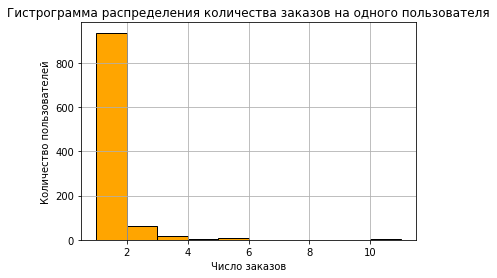

In [28]:
plt.hist(ordersByUsers['orders'], color='orange',  edgecolor = 'black') 
plt.grid()
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.xlabel('Число заказов')
plt.ylabel('Количество пользователей')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна.
Построим точечную диаграмму числа заказов на одного пользователя:

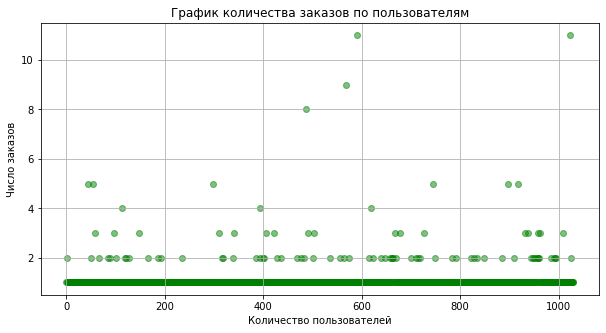

In [29]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(10,5))
plt.scatter(x_values, ordersByUsers['orders'], color='green', alpha=0.5)
plt.grid()
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Число заказов')
plt.show()


<b>ВЫВОД 3.6 </b>
    
Выводы подтверждаются: большинство пользователей совершили 1 заказ, также много пользователей с 2, и чуть менее 3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. Необходимо посчитать выборочные перцентили количества заказов на одного пользователя. Все, что выше трех заказов уже явно аномальные значения

### Граница заказов для определения аномальных пользователей

Посчитаем выборочные 95-й и 99-й перцентили количества заказов на одного пользователя

In [30]:
print('Выборочные 95-й и 99-й перцентили количества заказов на одного пользователя:')
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

Выборочные 95-й и 99-й перцентили количества заказов на одного пользователя:
[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. Посмотрим повнимательнее на персентели с 95-го по 99-й

In [31]:
print('Выборочные с 95-й по 99-й перцентили количества заказов на одного пользователя:')
print(np.percentile(ordersByUsers['orders'], [95,96,97,98,99])) 

Выборочные с 95-й по 99-й перцентили количества заказов на одного пользователя:
[2. 2. 2. 3. 4.]



<b>ВЫВОД 3.7 </b>
    
Таким образом, видим, что 98% пользователей совершают один или два заказа.    
Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

###  Точечный график стоимостей заказов

Аналогично проанализируем показатель стоимости заказов. Изучим данные о заказах, помним об аномально высоком заказе №425, равном 1294500 и максимальных после него значения в примерно 44 тысячи

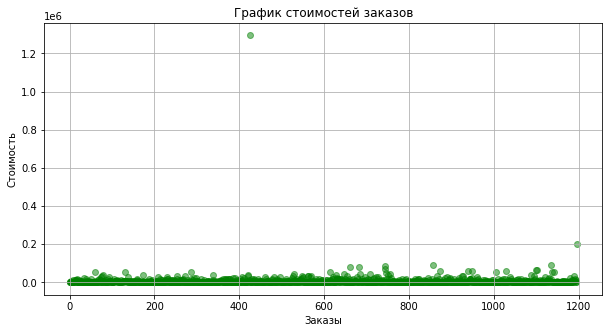

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], color='green',alpha=0.5)
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

Как и ожидалось, выброс смазал нам наглядность. В пределах от 200000 (еще один аномальный заказ) и выше значения заисключением аномального отсутствуют, отсечем их, посмотрим поближе

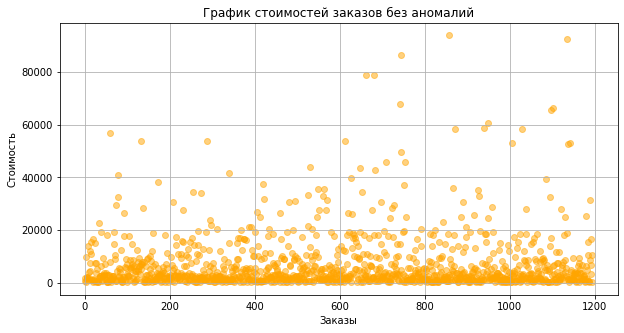

In [33]:
clean_orders = orders[orders['revenue']<=200000]['revenue']
xclean_values = pd.Series(range(0,len(clean_orders)))
plt.figure(figsize=(10,5))
plt.scatter(xclean_values, clean_orders, color='orange',alpha=0.5)
plt.grid()
plt.title('График стоимостей заказов без аномалий')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()


<b>ВЫВОД 3.8 </b>
    
За исключением аномальных двух аномальных заказов на ~1.3 млн и ~200 тыс. основная масса лежит в интервале до 20 тысяч, чуть меньше от 20 до 40 тысяч. Для того, чтобы найти более точную границу аномальных заказов, необходимо рассчитать перцентили.

###  Граница для определения аномальных заказов по выручке

Посчитаем выборочные 95-й и 99-й перцентили по выручке заказов



In [34]:
print('Выборочные 95-й и 99-й перцентили заказов по выручке:')
print(np.percentile(orders['revenue'], [95, 99])) 

Выборочные 95-й и 99-й перцентили заказов по выручке:
[28000.  58233.2]


 
<b>ВЫВОД 3.9 </b>
    
Видим, что 99% заказов были совершены на сумму <=58233.2. Считаю разумным установить ее в качестве границы для аномалий

###  Различия в конверсии между группами по «сырым» данным 

Сформулируем гипотезы:

***Н0*** - Статистически значимых различий в конверсии между группами по "сырым" данным нет

***Н1*** - Статистически значимые различия в конверсии между группами по "сырым" данным есть

Для начала необходимо собрать данные по заказам и визитам, добавив кумулятивные показатели, в одну таблицу. Создадим несколько таблиц и затем объединим их



In [35]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [36]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

Объединим:

In [37]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [38]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни. 

Число элементов sampleA — это количество пользователей, сумма всех элементов — это количество заказов. Для того, чтобы получить конверсию в группе, разделим сумму заказов на число пользователей — найдём среднее в выборке sampleA с помощью mean(). Аналогично найдём конверсию группы B.

In [39]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой.

In [40]:
print('alpha:', 0.05)
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print('Относительный показатель B к A: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1)) 

alpha: 0.05
p-value: 0.017
Относительный показатель B к A: 0.138



<b>ВЫВОД 3.10 </b>
    
Имеем:

Значение p-value = 0.017 и меньше принятого уровня alpha = 0.05, соответственно, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, - отвергаем. 
По «сырым» данным существуют статистически значимые различия в конверсии групп `A` и `B`. 

А относительное превосходство группы `B` над группой `A` составляет 13.8% .

###  Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным 

Сформулируем гипотезы:

***Н0*** - Статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет

***Н1*** - Статистически значимые различия в среднем чеке заказа между группами по "сырым" данным есть

Для расчета статистической значимости различий в среднем чеке между группами, передадим критерию mannwhitneyu() данные о выручке с заказов (пороговое значение примем в 5%) и найдём относительные различия в среднем чеке между группами.



In [41]:
print('alpha: ',0.05)
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительный показатель B к A: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha:  0.05
p-value: 0.729
Относительный показатель B к A: 0.259



<b>ВЫВОД 3.11 </b>
    
Имеем:

Значение p-value = 0.729 и много больше принятого уровня alpha = 0.05, соответственно, нулевую гипотезу о том, что статистически значимых различий  в среднем чеке заказа между группами нет, не отвергаем. 
По «сырым» данным не существует статистически значимых различий в среднем чеке заказа групп `A` и `B`. 

Однако, средний чек группы `B` почти на 26% выше среднего чека группы `A`.

###  Статистическая значимость различий в конверсии между группами по «очищенным» данным 

Сформулируем гипотезы:

***Н0*** - Статистически значимых различий в конверсии между группами по "очищенным" данным нет

***Н1*** - Статистически значимые различия в конверсии между группами по "очищенным" данным есть

Принятые **аномальные данные**:

Пользователи -  кто совершил **3 и больше заказов** или совершил заказ **дороже 58233.2**.

Сделаем срезы:
- с числом заказов больше 2 — `usersWithManyOrders` 
- пользователей, совершивших заказы дороже 58233.2 — `usersWithExpensiveOrders`. 

Объединим их в таблице `abnormalUsers`. Узнаем, сколько всего аномальных пользователей.



In [42]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233.2]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Количество аномальных пользователей равно', abnormalUsers.shape[0])

Количество аномальных пользователей равно 31


Для того, чтобы понять, действия этих 31 пользователей повлияли на результаты теста, расчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

Для начала подготовим выборки количества заказов по пользователям по группам теста:

In [43]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

Применим критерий Манна-Уитни к полученным выборкам:

In [44]:
print('alpha:',0.05)
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('Относительный показатель B к A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha: 0.05
p-value: 0.010
Относительный показатель B к A: 0.174



<b>ВЫВОД 3.12 </b>
    
Имеем:

Значение p-value = 0.01 и меньше принятого уровня alpha = 0.05, соответственно, нулевую гипотезу о том, что  различий в конверсии между группами по "очищенным" данным нет,  отвергаем. 
По "очищенным" данным  существуют статистически значимые различия в конверсии групп `A` и `B`. 

А относительное превосходство группы B над группой A составляет 17,4% (выше, чем с «сырыми» данными, где 13.8%) 

###  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:

***Н0*** - Статистически значимых различий в среднем чеке заказа между группами по "очищенным" данным нет

***Н1*** - Статистически значимые различия в среднем чеке заказа между группами по "очищенным" данным есть


In [45]:
print('alpha:',0.05)
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print('Относительный показатель B к A: {0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha: 0.05
p-value: 0.798
Относительный показатель B к A: -0.020



<b>ВЫВОД 3.13 </b>
    
Имеем:

Значение p-value = 0.798 и много выше принятого уровня alpha = 0.05, соответственно, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами по "очищенным" данным нет, не отвергаем.
    
По "очищенным" данным  не существует статистически значимых различий в среднем чеке заказа групп `A` и `B`. (как и в случае "сырых" данных)

Однако, средний чек группы `B` оказался незначительно (на 2%) ниже среднего чека группы `A`, тогда как по "сырым" данным, он был много больше (на ~26%). Это объясняется как раз аномальным заказом №425.


    
###  Решение по результатам теста

Имеющиеся факты:

1. **Существует** статистически значимое **различие по конверсии** между группами как **по «сырым»** (`B` к `A` **13.8%**) , так и по данным **после фильтрации** аномалий (`B` к `A` **17.4%**). 
2. **Нет** статистически значимого **различия по среднему чеку** между группами **ни по «сырым»**, **ни** по данным **после фильтрации** аномалий. Средний чек группы `B` оказался незначительно (на 2%) ниже среднего чека группы `A` по "очищенным" данным (по "сырым" данным, он был больше аж на ~26%).
3. **График различия конверсии** между группами сообщает, что результаты группы `A` хуже группы `B` и нет значительной тенденции к улучшению.
4. **График различия среднего чека** говорит о том, что результаты обеих групп были бы распределены равномерно, если бы не аномальный скачок в группе `B`.

***Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы `B`, которая значительно эффективнее сегмента `A` в части конверсии, при том, что в разрезе среднего чека сегменты примерно равны.***


    
# Общие выводы
В ходе исследования были проведены следующие работы:

**1  Предобработка данных**

Было обработано три датасета `hypothesis`, `orders` и `visitors`, данные в них представлены полные, корректные, дубликатов нет. Произведена замена названия столбцов и типа столбцов с датами на "datetime"

**2  Приоритизация гипотез**

После применения фреймворков ICE и RICE для приоритизации гипотез определено различие в приоритизации гипотез, обусловленое учетом во фреймворке RICE параметра reach. Сформированы **рекомендации для** проведения **тестирования** следующих **гипотез**:
***а). Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (точно)
б). Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (возможно)***

**3 Анализ A/B-теста**

1.	Построены по группам графики кумулятивных выручки, среднего чека, относительного изменения кумулятивного среднего чека,  конверсии,  относительного изменения кумулятивной конверсии; 
2.	Построен точечный график количества заказов по пользователям, выбрана **граница** для определения аномальных пользователей (**2 заказа на одного пользователя**).
3.	Построен точечный график стоимостей заказов, выбрана  **граница** для определения аномальных заказов (**=58233.2 у.е.**).
4.	Посчитаны статистические значимости различий между группами по «сырым» и «очищенным»  в конверсии и  в среднем чеке заказа
- **По «сырым**» данным **существуют** статистически значимые **различия в конверсии** групп `A` и `B`
- **По «сырым»** данным **не существует** статистически значимых **различий в среднем чеке заказа** групп `A` и `B`
- **По "очищенным"** данным  **существуют** статистически значимые **различия в конверсии** групп `A` и `B`
- **По "очищенным"** данным **не существует** статистически значимых **различий в среднем чеке заказа** групп `A` и `B`.
5.	Принято  решение по результатам: **тест следует остановить и зафиксировать победу группы B**
